In [1]:
%pylab inline

import pandas as pd
import numpy as np

# for calculating accurate distances betwen lat/long points
from geopy.distance import vincenty

from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.constants.constants import F2C

from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import data
mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")

train = pd.read_csv('../input/train.csv')[['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent']]
test = pd.read_csv('../input/test.csv')[['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy']]

weather = pd.read_csv('../input/weather.csv')[['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']]

In [3]:
# precompute trap counts
traps = np.unique(train['Trap'])
n_traps = traps.size
trap_count = np.empty(n_traps, dtype=int)
for i in range(n_traps):
    trap_count[i] = train[(train.Trap == traps[i]) & (train.WnvPresent == 1)].as_matrix().shape[0]
#print sum(trap_count)
trap_dict = dict(zip(traps, trap_count))
#print trap_dict

# get species info
species = np.unique(train['Species'])
n_species = species.size
#print species

# replace 
stations = np.unique(weather['Station'])
weather_features = ['Tmin', 'Tmax', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']
#print weather[weather_features].replace('\D+', 0, regex=True)

weather_header = []
for s in stations:
    for f in weather_features:
        weather_header.append(f + str(s))

# reference lat/long for chicago
ll_chicago = (41.8369, -87.6847)

# data header
header = np.hstack((np.array(['dx', 'dy', 'dt', 'tc']), species, weather_header))
n_features = header.size

In [4]:
x = train.iloc[0]
d = x['Date']
w = np.hstack(weather[weather.Date == d][weather_features].replace('\D+', 0, regex=True).as_matrix()).astype(float64)
wt = np.hstack(weather[weather.Date == d][weather_features].replace('[a-zA-Z]', 0, regex=True).as_matrix()).astype(float64)
print [wt, w]

[array([ 60.  ,  88.  ,  74.  ,  58.  ,  65.  ,   0.  ,   9.  ,   0.  ,
        29.39,  30.11,   5.8 ,  18.  ,   6.5 ,  65.  ,  88.  ,  77.  ,
        59.  ,  66.  ,   0.  ,  12.  ,   0.  ,  29.44,  30.09,   5.8 ,
        16.  ,   7.4 ]), array([ 60. ,  88. ,  74. ,  58. ,  65. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   5.8,  18. ,   0. ,  65. ,  88. ,  77. ,  59. ,  66. ,
         0. ,  12. ,   0. ,   0. ,   0. ,   5.8,  16. ,   0. ])]


In [5]:
# function for generating features
def gen_features(data):
    m = data.shape[0]
    X = np.empty((m, n_features), dtype=float64)
   
    for i in range(m):
        x = data.iloc[i]
        ll = x[['Latitude', 'Longitude']].as_matrix()
        d = x['Date']
        s = x['Species']
        t = x['Trap']
        #w = np.hstack(weather[weather.Date == d][weather_features].as_matrix())
        #w[:] = [float(re.sub("\D", "0", j)) for j in w]
        w = np.hstack(weather[weather.Date == d][weather_features].replace('[a-zA-Z]', 0, regex=True).as_matrix()).astype(float64)

        # get dx and dy
        dx = vincenty(ll_chicago, (ll_chicago[0], ll[1])).meters
        if(ll_chicago[1] > ll[1]):
            dx *= -1
        dy = vincenty(ll_chicago, (ll[0], ll_chicago[1])).meters
        if(ll_chicago[0] > ll[0]):
            dy *= -1

        # get day of year
        d1 = datetime.strptime(d, "%Y-%m-%d")
        d0 = datetime.strptime(str(d1.year) + "-01-01", "%Y-%m-%d")
        dt = abs((d1 - d0).days)

        # get trap count
        if t in trap_dict:
            tc = trap_dict[t]
        else:
            tc = 0

        # get species array
        sa = np.array(s == species).astype(int)

        X[i, :] = np.hstack((np.array([dx, dy, dt, tc]), sa, w))
    
    return X

In [6]:
# generate features
X_train = gen_features(train)
y_train = train[['WnvPresent']].as_matrix()
X_test = gen_features(test)

In [8]:
# output csv
train_df = pd.DataFrame(np.hstack((y_train, X_train)), columns=np.hstack(('label', header)))
train_df.to_csv('../working/train_f.csv')
test_df = pd.DataFrame(X_test, columns=header)
test_df.to_csv('../working/test_f.csv')

(551, 12)


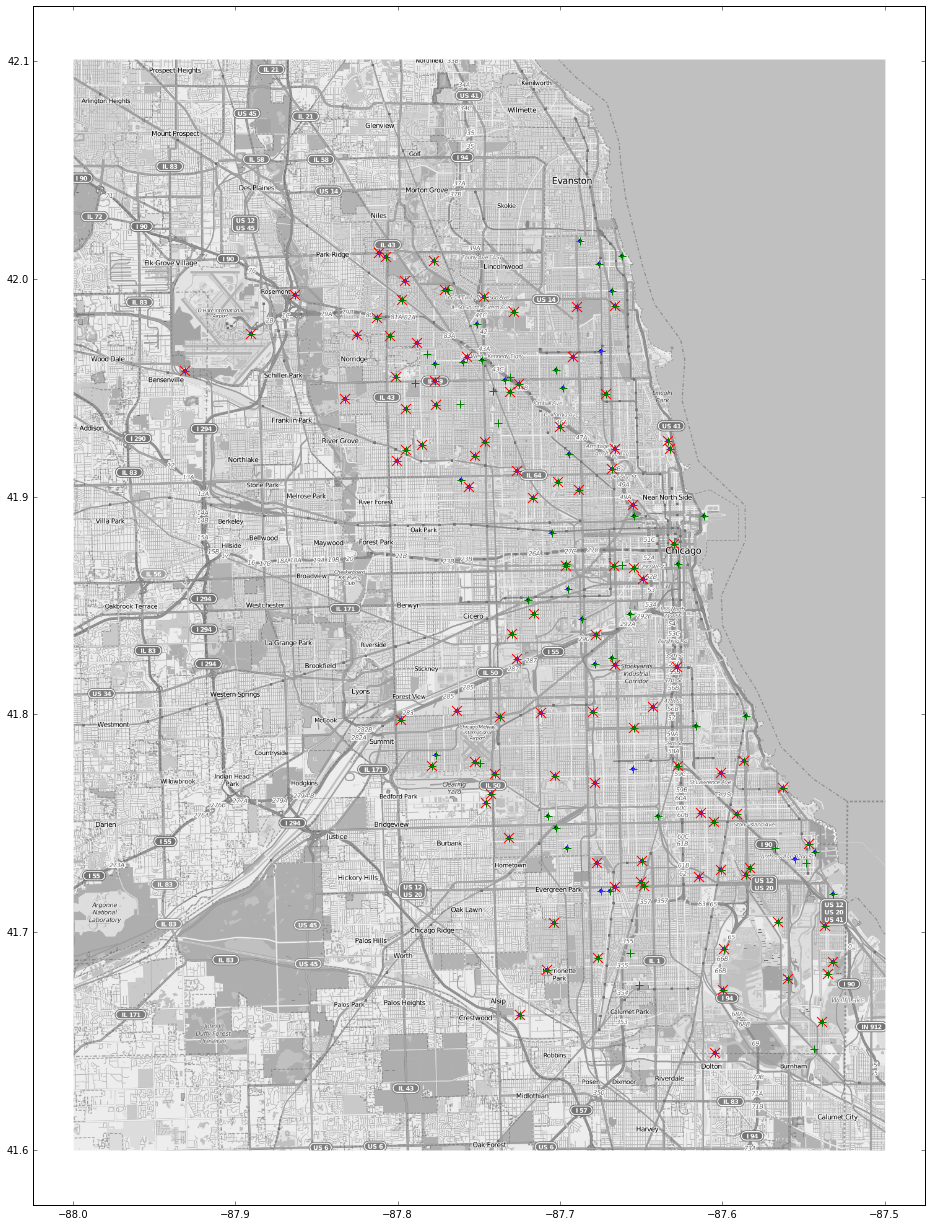

In [9]:
# generate map
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

fig, ax = plt.subplots()
fig.set_size_inches(16, aspect*16)

ax.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)

train_loc = train[['Longitude', 'Latitude']].drop_duplicates().values
ax.scatter(train_loc[:,0], train_loc[:,1], marker='.', color='b', s=30)

wnv_present = train[train.WnvPresent > 0]
print wnv_present.shape
wnv_loc = wnv_present[['Longitude', 'Latitude']].drop_duplicates().values
ax.scatter(wnv_loc[:,0], wnv_loc[:,1], marker='x', color='r', s=100)

test_loc = test[['Longitude', 'Latitude']].drop_duplicates().values
ax.scatter(test_loc[:,0], test_loc[:,1], marker='+', color='g', s=50)

#train_vor = Voronoi(train_loc)
#voronoi_plot_2d(train_vor, ax=ax)

plt.show()